<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/HookedCursiveTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/zwimpee/cursivetransformer/issues/26

We will find this post particularly useful: https://arena3-chapter1-transformer-interp.streamlit.app/[1.1]_Transformer_from_Scratch
As well as this notebook: https://colab.research.google.com/drive/1bZkkJd8pAVnSN23svyszZ3f4WrnYKN_3?usp=sharing

# Setup

In [1]:
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

# Login to Weights & Biases (replace 'your_api_key' with your actual API key)
import wandb
wandb.login()

import sys
sys.path.append('/content/cursivetransformer')  # Adjust the path if necessary

# Import cursivetransformer modules
from cursivetransformer.model import get_all_args, get_checkpoint
from cursivetransformer.data import create_datasets, offsets_to_strokes
from cursivetransformer.sample import generate, generate_n_words, plot_strokes

# Import TransformerLens modules
from transformer_lens import HookedTransformer

# Import other necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gradio as gr
import pprint
import json
from datasets import load_dataset
from IPython.display import HTML, display
from functools import partial
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from einops import rearrange


args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

model, optimizer, scheduler, step, best_loss = get_checkpoint(args)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Fo

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples
Number of Transformer parameters: 368064
Model #params: 397184
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_che

wandb:   1 of 1 files downloaded.  


# Modified TransformerLens/transformer_lens/loading_from_pretrained.py
- https://github.com/TransformerLensOrg/TransformerLens/blob/main/transformer_lens/loading_from_pretrained.py

## Setup

In [2]:
"""Loading Pretrained Models Utilities.

This module contains functions for loading pretrained models from the Hugging Face Hub.
"""

import dataclasses
import logging
import os
import re
from pathlib import Path
from typing import Dict, Optional, Union

import torch
from huggingface_hub import HfApi
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    BertForPreTraining,
    T5ForConditionalGeneration,
)

import transformer_lens.utils as utils
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig
from transformer_lens.pretrained.weight_conversions import (
    convert_bert_weights,
    convert_bloom_weights,
    convert_coder_weights,
    convert_gemma_weights,
    convert_gpt2_weights,
    convert_gptj_weights,
    convert_llama_weights,
    convert_mingpt_weights,
    convert_mistral_weights,
    convert_mixtral_weights,
    convert_neel_solu_old_weights,
    convert_neo_weights,
    convert_neox_weights,
    convert_opt_weights,
    convert_phi3_weights,
    convert_phi_weights,
    convert_qwen2_weights,
    convert_qwen_weights,
    convert_t5_weights,
)

OFFICIAL_MODEL_NAMES = [
    "gpt2",
    "gpt2-medium",
    "gpt2-large",
    "gpt2-xl",
    "distilgpt2",
    "facebook/opt-125m",
    "facebook/opt-1.3b",
    "facebook/opt-2.7b",
    "facebook/opt-6.7b",
    "facebook/opt-13b",
    "facebook/opt-30b",
    "facebook/opt-66b",
    "EleutherAI/gpt-neo-125M",
    "EleutherAI/gpt-neo-1.3B",
    "EleutherAI/gpt-neo-2.7B",
    "EleutherAI/gpt-j-6B",
    "EleutherAI/gpt-neox-20b",
    "stanford-crfm/alias-gpt2-small-x21",
    "stanford-crfm/battlestar-gpt2-small-x49",
    "stanford-crfm/caprica-gpt2-small-x81",
    "stanford-crfm/darkmatter-gpt2-small-x343",
    "stanford-crfm/expanse-gpt2-small-x777",
    "stanford-crfm/arwen-gpt2-medium-x21",
    "stanford-crfm/beren-gpt2-medium-x49",
    "stanford-crfm/celebrimbor-gpt2-medium-x81",
    "stanford-crfm/durin-gpt2-medium-x343",
    "stanford-crfm/eowyn-gpt2-medium-x777",
    "EleutherAI/pythia-14m",
    "EleutherAI/pythia-31m",
    "EleutherAI/pythia-70m",
    "EleutherAI/pythia-160m",
    "EleutherAI/pythia-410m",
    "EleutherAI/pythia-1b",
    "EleutherAI/pythia-1.4b",
    "EleutherAI/pythia-2.8b",
    "EleutherAI/pythia-6.9b",
    "EleutherAI/pythia-12b",
    "EleutherAI/pythia-70m-deduped",
    "EleutherAI/pythia-160m-deduped",
    "EleutherAI/pythia-410m-deduped",
    "EleutherAI/pythia-1b-deduped",
    "EleutherAI/pythia-1.4b-deduped",
    "EleutherAI/pythia-2.8b-deduped",
    "EleutherAI/pythia-6.9b-deduped",
    "EleutherAI/pythia-12b-deduped",
    "EleutherAI/pythia-70m-v0",
    "EleutherAI/pythia-160m-v0",
    "EleutherAI/pythia-410m-v0",
    "EleutherAI/pythia-1b-v0",
    "EleutherAI/pythia-1.4b-v0",
    "EleutherAI/pythia-2.8b-v0",
    "EleutherAI/pythia-6.9b-v0",
    "EleutherAI/pythia-12b-v0",
    "EleutherAI/pythia-70m-deduped-v0",
    "EleutherAI/pythia-160m-deduped-v0",
    "EleutherAI/pythia-410m-deduped-v0",
    "EleutherAI/pythia-1b-deduped-v0",
    "EleutherAI/pythia-1.4b-deduped-v0",
    "EleutherAI/pythia-2.8b-deduped-v0",
    "EleutherAI/pythia-6.9b-deduped-v0",
    "EleutherAI/pythia-12b-deduped-v0",
    "EleutherAI/pythia-160m-seed1",
    "EleutherAI/pythia-160m-seed2",
    "EleutherAI/pythia-160m-seed3",
    "NeelNanda/SoLU_1L_v9_old",
    "NeelNanda/SoLU_2L_v10_old",
    "NeelNanda/SoLU_4L_v11_old",
    "NeelNanda/SoLU_6L_v13_old",
    "NeelNanda/SoLU_8L_v21_old",
    "NeelNanda/SoLU_10L_v22_old",
    "NeelNanda/SoLU_12L_v23_old",
    "NeelNanda/SoLU_1L512W_C4_Code",
    "NeelNanda/SoLU_2L512W_C4_Code",
    "NeelNanda/SoLU_3L512W_C4_Code",
    "NeelNanda/SoLU_4L512W_C4_Code",
    "NeelNanda/SoLU_6L768W_C4_Code",
    "NeelNanda/SoLU_8L1024W_C4_Code",
    "NeelNanda/SoLU_10L1280W_C4_Code",
    "NeelNanda/SoLU_12L1536W_C4_Code",
    "NeelNanda/GELU_1L512W_C4_Code",
    "NeelNanda/GELU_2L512W_C4_Code",
    "NeelNanda/GELU_3L512W_C4_Code",
    "NeelNanda/GELU_4L512W_C4_Code",
    "NeelNanda/Attn_Only_1L512W_C4_Code",
    "NeelNanda/Attn_Only_2L512W_C4_Code",
    "NeelNanda/Attn_Only_3L512W_C4_Code",
    "NeelNanda/Attn_Only_4L512W_C4_Code",
    "NeelNanda/Attn-Only-2L512W-Shortformer-6B-big-lr",
    "NeelNanda/SoLU_1L512W_Wiki_Finetune",
    "NeelNanda/SoLU_4L512W_Wiki_Finetune",
    "ArthurConmy/redwood_attn_2l",
    "llama-7b-hf",
    "llama-13b-hf",
    "llama-30b-hf",
    "llama-65b-hf",
    "meta-llama/Llama-2-7b-hf",
    "meta-llama/Llama-2-7b-chat-hf",
    "meta-llama/Llama-2-13b-hf",
    "meta-llama/Llama-2-13b-chat-hf",
    "meta-llama/Llama-2-70b-chat-hf",
    "CodeLlama-7b-hf",
    "CodeLlama-7b-Python-hf",
    "CodeLlama-7b-Instruct-hf",
    "meta-llama/Meta-Llama-3-8B",
    "meta-llama/Meta-Llama-3-8B-Instruct",
    "meta-llama/Meta-Llama-3-70B",
    "meta-llama/Meta-Llama-3-70B-Instruct",
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "Baidicoot/Othello-GPT-Transformer-Lens",
    "bert-base-cased",
    "roneneldan/TinyStories-1M",
    "roneneldan/TinyStories-3M",
    "roneneldan/TinyStories-8M",
    "roneneldan/TinyStories-28M",
    "roneneldan/TinyStories-33M",
    "roneneldan/TinyStories-Instruct-1M",
    "roneneldan/TinyStories-Instruct-3M",
    "roneneldan/TinyStories-Instruct-8M",
    "roneneldan/TinyStories-Instruct-28M",
    "roneneldan/TinyStories-Instruct-33M",
    "roneneldan/TinyStories-1Layer-21M",
    "roneneldan/TinyStories-2Layers-33M",
    "roneneldan/TinyStories-Instuct-1Layer-21M",
    "roneneldan/TinyStories-Instruct-2Layers-33M",
    "stabilityai/stablelm-base-alpha-3b",
    "stabilityai/stablelm-base-alpha-7b",
    "stabilityai/stablelm-tuned-alpha-3b",
    "stabilityai/stablelm-tuned-alpha-7b",
    "mistralai/Mistral-7B-v0.1",
    "mistralai/Mistral-7B-Instruct-v0.1",
    "mistralai/Mixtral-8x7B-v0.1",
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    "bigscience/bloom-560m",
    "bigscience/bloom-1b1",
    "bigscience/bloom-1b7",
    "bigscience/bloom-3b",
    "bigscience/bloom-7b1",
    "bigcode/santacoder",
    "Qwen/Qwen-1_8B",
    "Qwen/Qwen-7B",
    "Qwen/Qwen-14B",
    "Qwen/Qwen-1_8B-Chat",
    "Qwen/Qwen-7B-Chat",
    "Qwen/Qwen-14B-Chat",
    "Qwen/Qwen1.5-0.5B",
    "Qwen/Qwen1.5-0.5B-Chat",
    "Qwen/Qwen1.5-1.8B",
    "Qwen/Qwen1.5-1.8B-Chat",
    "Qwen/Qwen1.5-4B",
    "Qwen/Qwen1.5-4B-Chat",
    "Qwen/Qwen1.5-7B",
    "Qwen/Qwen1.5-7B-Chat",
    "Qwen/Qwen1.5-14B",
    "Qwen/Qwen1.5-14B-Chat",
    "Qwen/Qwen2-0.5B",
    "Qwen/Qwen2-0.5B-Instruct",
    "Qwen/Qwen2-1.5B",
    "Qwen/Qwen2-1.5B-Instruct",
    "Qwen/Qwen2-7B",
    "Qwen/Qwen2-7B-Instruct",
    "microsoft/phi-1",
    "microsoft/phi-1_5",
    "microsoft/phi-2",
    "microsoft/Phi-3-mini-4k-instruct",
    "google/gemma-2b",
    "google/gemma-7b",
    "google/gemma-2b-it",
    "google/gemma-7b-it",
    "google/gemma-2-2b",
    "google/gemma-2-2b-it",
    "google/gemma-2-9b",
    "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "google/gemma-2-27b-it",
    "01-ai/Yi-6B",
    "01-ai/Yi-34B",
    "01-ai/Yi-6B-Chat",
    "01-ai/Yi-34B-Chat",
    "google-t5/t5-small",
    "google-t5/t5-base",
    "google-t5/t5-large",
    "ai-forever/mGPT",
]
"""Official model names for models on HuggingFace."""

# Model Aliases:
MODEL_ALIASES = {
    "NeelNanda/SoLU_1L_v9_old": ["solu-1l-pile", "solu-1l-old"],
    "NeelNanda/SoLU_2L_v10_old": ["solu-2l-pile", "solu-2l-old"],
    "NeelNanda/SoLU_4L_v11_old": ["solu-4l-pile", "solu-4l-old"],
    "NeelNanda/SoLU_6L_v13_old": ["solu-6l-pile", "solu-6l-old"],
    "NeelNanda/SoLU_8L_v21_old": ["solu-8l-pile", "solu-8l-old"],
    "NeelNanda/SoLU_10L_v22_old": ["solu-10l-pile", "solu-10l-old"],
    "NeelNanda/SoLU_12L_v23_old": ["solu-12l-pile", "solu-12l-old"],
    "NeelNanda/SoLU_1L512W_C4_Code": ["solu-1l", "solu-1l-new", "solu-1l-c4-code"],
    "NeelNanda/SoLU_2L512W_C4_Code": ["solu-2l", "solu-2l-new", "solu-2l-c4-code"],
    "NeelNanda/SoLU_3L512W_C4_Code": ["solu-3l", "solu-3l-new", "solu-3l-c4-code"],
    "NeelNanda/SoLU_4L512W_C4_Code": ["solu-4l", "solu-4l-new", "solu-4l-c4-code"],
    "NeelNanda/GELU_1L512W_C4_Code": ["gelu-1l", "gelu-1l-new", "gelu-1l-c4-code"],
    "NeelNanda/GELU_2L512W_C4_Code": ["gelu-2l", "gelu-2l-new", "gelu-2l-c4-code"],
    "NeelNanda/GELU_3L512W_C4_Code": ["gelu-3l", "gelu-3l-new", "gelu-3l-c4-code"],
    "NeelNanda/GELU_4L512W_C4_Code": ["gelu-4l", "gelu-4l-new", "gelu-4l-c4-code"],
    "NeelNanda/Attn_Only_1L512W_C4_Code": [
        "attn-only-1l",
        "attn-only-1l-new",
        "attn-only-1l-c4-code",
    ],
    "NeelNanda/Attn_Only_2L512W_C4_Code": [
        "attn-only-2l",
        "attn-only-2l-new",
        "attn-only-2l-c4-code",
    ],
    "NeelNanda/Attn_Only_3L512W_C4_Code": [
        "attn-only-3l",
        "attn-only-3l-new",
        "attn-only-3l-c4-code",
    ],
    "NeelNanda/Attn_Only_4L512W_C4_Code": [
        "attn-only-4l",
        "attn-only-4l-new",
        "attn-only-4l-c4-code",
    ],
    "NeelNanda/SoLU_6L768W_C4_Code": ["solu-6l", "solu-6l-new", "solu-6l-c4-code"],
    "NeelNanda/SoLU_8L1024W_C4_Code": ["solu-8l", "solu-8l-new", "solu-8l-c4-code"],
    "NeelNanda/SoLU_10L1280W_C4_Code": ["solu-10l", "solu-10l-new", "solu-10l-c4-code"],
    "NeelNanda/SoLU_12L1536W_C4_Code": ["solu-12l", "solu-12l-new", "solu-12l-c4-code"],
    "NeelNanda/Attn-Only-2L512W-Shortformer-6B-big-lr": [
        "attn-only-2l-demo",
        "attn-only-2l-shortformer-6b-big-lr",
        "attn-only-2l-induction-demo",
        "attn-only-demo",
    ],
    "NeelNanda/SoLU_1L512W_Wiki_Finetune": [
        "solu-1l-wiki",
        "solu-1l-wiki-finetune",
        "solu-1l-finetune",
    ],
    "NeelNanda/SoLU_4L512W_Wiki_Finetune": [
        "solu-4l-wiki",
        "solu-4l-wiki-finetune",
        "solu-4l-finetune",
    ],
    "EleutherAI/pythia-14m": [
        "pythia-14m",
    ],
    "EleutherAI/pythia-31m": [
        "pythia-31m",
    ],
    "EleutherAI/pythia-70m": [
        "pythia-70m",
        "pythia",
        "EleutherAI/pythia-19m",
        "pythia-19m",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-160m": [
        "pythia-160m",
        "EleutherAI/pythia-125m",
        "pythia-125m",  # EleutherAI renamed this model"
    ],
    "EleutherAI/pythia-410m": [
        "pythia-410m",
        "EleutherAI/pythia-350m",
        "pythia-350m",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-1b": [
        "pythia-1b",
        "EleutherAI/pythia-800m",
        "pythia-800m",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-1.4b": [
        "pythia-1.4b",
        "EleutherAI/pythia-1.3b",
        "pythia-1.3b",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-2.8b": [
        "pythia-2.8b",
        "EleutherAI/pythia-2.7b",
        "pythia-2.7b",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-6.9b": [
        "pythia-6.9b",
        "EleutherAI/pythia-6.7b",
        "pythia-6.7b",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-12b": [
        "pythia-12b",
        "EleutherAI/pythia-13b",
        "pythia-13b",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-70m-deduped": [
        "pythia-70m-deduped",
        "EleutherAI/pythia-19m-deduped",  # EleutherAI renamed this model
        "pythia-19m-deduped",
    ],
    "EleutherAI/pythia-160m-deduped": [
        "pythia-160m-deduped",
        "EleutherAI/pythia-125m-deduped",  # EleutherAI renamed this model
        "pythia-125m-deduped",
    ],
    "EleutherAI/pythia-410m-deduped": [
        "pythia-410m-deduped",
        "EleutherAI/pythia-350m-deduped",  # EleutherAI renamed this model
        "pythia-350m-deduped",
    ],
    "EleutherAI/pythia-1b-deduped": [
        "pythia-1b-deduped",
        "EleutherAI/pythia-800m-deduped",  # EleutherAI renamed this model
        "pythia-800m-deduped",
    ],
    "EleutherAI/pythia-1.4b-deduped": [
        "pythia-1.4b-deduped",
        "EleutherAI/pythia-1.3b-deduped",  # EleutherAI renamed this model
        "pythia-1.3b-deduped",
    ],
    "EleutherAI/pythia-2.8b-deduped": [
        "pythia-2.8b-deduped",
        "EleutherAI/pythia-2.7b-deduped",  # EleutherAI renamed this model
        "pythia-2.7b-deduped",
    ],
    "EleutherAI/pythia-6.9b-deduped": [
        "pythia-6.9b-deduped",
        "EleutherAI/pythia-6.7b-deduped",  # EleutherAI renamed this model
        "pythia-6.7b-deduped",
    ],
    "EleutherAI/pythia-12b-deduped": [
        "pythia-12b-deduped",
        "EleutherAI/pythia-13b-deduped",  # EleutherAI renamed this model
        "pythia-13b-deduped",
    ],
    "EleutherAI/pythia-70m-v0": [
        "pythia-70m-v0",
        "pythia-v0",
        "EleutherAI/pythia-19m-v0",
        "pythia-19m-v0",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-160m-v0": [
        "pythia-160m-v0",
        "EleutherAI/pythia-125m-v0",
        "pythia-125m-v0",  # EleutherAI renamed this model"
    ],
    "EleutherAI/pythia-410m-v0": [
        "pythia-410m-v0",
        "EleutherAI/pythia-350m-v0",
        "pythia-350m-v0",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-1b-v0": [
        "pythia-1b-v0",
        "EleutherAI/pythia-800m-v0",
        "pythia-800m-v0",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-1.4b-v0": [
        "pythia-1.4b-v0",
        "EleutherAI/pythia-1.3b-v0",
        "pythia-1.3b-v0",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-2.8b-v0": [
        "pythia-2.8b-v0",
        "EleutherAI/pythia-2.7b-v0",
        "pythia-2.7b-v0",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-6.9b-v0": [
        "pythia-6.9b-v0",
        "EleutherAI/pythia-6.7b-v0",
        "pythia-6.7b-v0",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-12b-v0": [
        "pythia-12b-v0",
        "EleutherAI/pythia-13b-v0",
        "pythia-13b-v0",  # EleutherAI renamed this model
    ],
    "EleutherAI/pythia-70m-deduped-v0": [
        "pythia-70m-deduped-v0",
        "EleutherAI/pythia-19m-deduped-v0",  # EleutherAI renamed this model
        "pythia-19m-deduped-v0",
    ],
    "EleutherAI/pythia-160m-deduped-v0": [
        "pythia-160m-deduped-v0",
        "EleutherAI/pythia-125m-deduped-v0",  # EleutherAI renamed this model
        "pythia-125m-deduped-v0",
    ],
    "EleutherAI/pythia-410m-deduped-v0": [
        "pythia-410m-deduped-v0",
        "EleutherAI/pythia-350m-deduped-v0",  # EleutherAI renamed this model
        "pythia-350m-deduped-v0",
    ],
    "EleutherAI/pythia-1b-deduped-v0": [
        "pythia-1b-deduped-v0",
        "EleutherAI/pythia-800m-deduped-v0",  # EleutherAI renamed this model
        "pythia-800m-deduped-v0",
    ],
    "EleutherAI/pythia-1.4b-deduped-v0": [
        "pythia-1.4b-deduped-v0",
        "EleutherAI/pythia-1.3b-deduped-v0",  # EleutherAI renamed this model
        "pythia-1.3b-deduped-v0",
    ],
    "EleutherAI/pythia-2.8b-deduped-v0": [
        "pythia-2.8b-deduped-v0",
        "EleutherAI/pythia-2.7b-deduped-v0",  # EleutherAI renamed this model
        "pythia-2.7b-deduped-v0",
    ],
    "EleutherAI/pythia-6.9b-deduped-v0": [
        "pythia-6.9b-deduped-v0",
        "EleutherAI/pythia-6.7b-deduped-v0",  # EleutherAI renamed this model
        "pythia-6.7b-deduped-v0",
    ],
    "EleutherAI/pythia-12b-deduped-v0": [
        "pythia-12b-deduped-v0",
        "EleutherAI/pythia-13b-deduped-v0",  # EleutherAI renamed this model
        "pythia-13b-deduped-v0",
    ],
    "EleutherAI/pythia-160m-seed1": [
        "pythia-160m-seed1",
        "EleutherAI/pythia-125m-seed1",
        "pythia-125m-seed1",  # EleutherAI renamed this model"
    ],
    "EleutherAI/pythia-160m-seed2": [
        "pythia-160m-seed2",
        "EleutherAI/pythia-125m-seed2",
        "pythia-125m-seed2",  # EleutherAI renamed this model"
    ],
    "EleutherAI/pythia-160m-seed3": [
        "pythia-160m-seed3",
        "EleutherAI/pythia-125m-seed3",
        "pythia-125m-seed3",  # EleutherAI renamed this model"
    ],
    "gpt2": ["gpt2-small"],
    "distilgpt2": ["distillgpt2", "distill-gpt2", "distil-gpt2", "gpt2-xs"],
    "facebook/opt-125m": ["opt-125m", "opt-small", "opt"],
    "facebook/opt-1.3b": ["opt-1.3b", "opt-medium"],
    "facebook/opt-2.7b": ["opt-2.7b", "opt-large"],
    "facebook/opt-6.7b": ["opt-6.7b", "opt-xl"],
    "facebook/opt-13b": ["opt-13b", "opt-xxl"],
    "facebook/opt-30b": ["opt-30b", "opt-xxxl"],
    "facebook/opt-66b": ["opt-66b", "opt-xxxxl"],
    "EleutherAI/gpt-neo-125M": ["gpt-neo-125M", "gpt-neo-small", "neo-small", "neo"],
    "EleutherAI/gpt-neo-1.3B": ["gpt-neo-1.3B", "gpt-neo-medium", "neo-medium"],
    "EleutherAI/gpt-neo-2.7B": ["gpt-neo-2.7B", "gpt-neo-large", "neo-large"],
    "EleutherAI/gpt-j-6B": ["gpt-j-6B", "gpt-j", "gptj"],
    "EleutherAI/gpt-neox-20b": ["gpt-neox-20b", "gpt-neox", "neox"],
    "stanford-crfm/alias-gpt2-small-x21": [
        "stanford-gpt2-small-a",
        "alias-gpt2-small-x21",
        "gpt2-mistral-small-a",
        "gpt2-stanford-small-a",
    ],
    "stanford-crfm/battlestar-gpt2-small-x49": [
        "stanford-gpt2-small-b",
        "battlestar-gpt2-small-x49",
        "gpt2-mistral-small-b",
        "gpt2-mistral-small-b",
    ],
    "stanford-crfm/caprica-gpt2-small-x81": [
        "stanford-gpt2-small-c",
        "caprica-gpt2-small-x81",
        "gpt2-mistral-small-c",
        "gpt2-stanford-small-c",
    ],
    "stanford-crfm/darkmatter-gpt2-small-x343": [
        "stanford-gpt2-small-d",
        "darkmatter-gpt2-small-x343",
        "gpt2-mistral-small-d",
        "gpt2-mistral-small-d",
    ],
    "stanford-crfm/expanse-gpt2-small-x777": [
        "stanford-gpt2-small-e",
        "expanse-gpt2-small-x777",
        "gpt2-mistral-small-e",
        "gpt2-mistral-small-e",
    ],
    "stanford-crfm/arwen-gpt2-medium-x21": [
        "stanford-gpt2-medium-a",
        "arwen-gpt2-medium-x21",
        "gpt2-medium-small-a",
        "gpt2-stanford-medium-a",
    ],
    "stanford-crfm/beren-gpt2-medium-x49": [
        "stanford-gpt2-medium-b",
        "beren-gpt2-medium-x49",
        "gpt2-medium-small-b",
        "gpt2-stanford-medium-b",
    ],
    "stanford-crfm/celebrimbor-gpt2-medium-x81": [
        "stanford-gpt2-medium-c",
        "celebrimbor-gpt2-medium-x81",
        "gpt2-medium-small-c",
        "gpt2-medium-small-c",
    ],
    "stanford-crfm/durin-gpt2-medium-x343": [
        "stanford-gpt2-medium-d",
        "durin-gpt2-medium-x343",
        "gpt2-medium-small-d",
        "gpt2-stanford-medium-d",
    ],
    "stanford-crfm/eowyn-gpt2-medium-x777": [
        "stanford-gpt2-medium-e",
        "eowyn-gpt2-medium-x777",
        "gpt2-medium-small-e",
        "gpt2-stanford-medium-e",
    ],
    "ArthurConmy/redwood_attn_2l": ["redwood_attn_2l"],
    "llama-7b-hf": ["llama-7b"],
    "llama-13b-hf": ["llama-13b"],
    "llama-30b-hf": ["llama-30b"],
    "llama-65b-hf": ["llama-65b"],
    "meta-llama/Llama-2-7b-hf": ["Llama-2-7b", "meta-llama/Llama-2-7b-hf"],
    "meta-llama/Llama-2-7b-chat-hf": [
        "Llama-2-7b-chat",
        "meta-llama/Llama-2-7b-chat-hf",
    ],
    "meta-llama/Llama-2-13b-hf": ["Llama-2-13b", "meta-llama/Llama-2-13b-hf"],
    "meta-llama/Llama-2-13b-chat-hf": [
        "Llama-2-13b-chat",
        "meta-llama/Llama-2-13b-chat-hf",
    ],
    "meta-llama/Llama-2-70b-chat-hf": ["Llama-2-70b-chat", "meta-llama-2-70b-chat-hf"],
    "CodeLlama-7b-hf": ["CodeLlamallama-2-7b", "codellama/CodeLlama-7b-hf"],
    "CodeLlama-7b-Python-hf": [
        "CodeLlama-7b-python",
        "codellama/CodeLlama-7b-Python-hf",
    ],
    "CodeLlama-7b-Instruct-hf": [
        "CodeLlama-7b-instruct",
        "codellama/CodeLlama-7b-Instruct-hf",
    ],
    "Baidicoot/Othello-GPT-Transformer-Lens": ["othello-gpt"],
    "roneneldan/TinyStories-1M": ["tiny-stories-1M"],
    "roneneldan/TinyStories-3M": ["tiny-stories-3M"],
    "roneneldan/TinyStories-8M": ["tiny-stories-8M"],
    "roneneldan/TinyStories-28M": ["tiny-stories-28M"],
    "roneneldan/TinyStories-33M": ["tiny-stories-33M"],
    "roneneldan/TinyStories-Instruct-1M": ["tiny-stories-instruct-1M"],
    "roneneldan/TinyStories-Instruct-3M": ["tiny-stories-instruct-3M"],
    "roneneldan/TinyStories-Instruct-8M": ["tiny-stories-instruct-8M"],
    "roneneldan/TinyStories-Instruct-28M": ["tiny-stories-instruct-28M"],
    "roneneldan/TinyStories-Instruct-33M": ["tiny-stories-instruct-33M"],
    "roneneldan/TinyStories-1Layer-21M": ["tiny-stories-1L-21M"],
    "roneneldan/TinyStories-2Layers-33M": ["tiny-stories-2L-33M"],
    "roneneldan/TinyStories-Instuct-1Layer-21M": ["tiny-stories-instruct-1L-21M"],
    "roneneldan/TinyStories-Instruct-2Layers-33M": ["tiny-stories-instruct-2L-33M"],
    "stabilityai/stablelm-base-alpha-3b": [
        "stablelm-base-alpha-3b",
        "stablelm-base-3b",
    ],
    "stabilityai/stablelm-base-alpha-7b": [
        "stablelm-base-alpha-7b",
        "stablelm-base-7b",
    ],
    "stabilityai/stablelm-tuned-alpha-3b": [
        "stablelm-tuned-alpha-3b",
        "stablelm-tuned-3b",
    ],
    "stabilityai/stablelm-tuned-alpha-7b": [
        "stablelm-tuned-alpha-7b",
        "stablelm-tuned-7b",
    ],
    "mistralai/Mistral-7B-v0.1": ["mistral-7b"],
    "mistralai/Mistral-7B-Instruct-v0.1": ["mistral-7b-instruct"],
    "mistralai/Mixtral-8x7B-v0.1": ["mixtral", "mixtral-8x7b"],
    "mistralai/Mixtral-8x7B-Instruct-v0.1": [
        "mixtral-instruct",
        "mixtral-8x7b-instruct",
    ],
    "bigscience/bloom-560m": ["bloom-560m"],
    "bigscience/bloom-1b1": ["bloom-1b1"],
    "bigscience/bloom-1b7": ["bloom-1b7"],
    "bigscience/bloom-3b": ["bloom-3b"],
    "bigscience/bloom-7b1": ["bloom-7b1"],
    "bigcode/santacoder": ["santacoder"],
    "Qwen/Qwen-1_8B": ["qwen-1.8b"],
    "Qwen/Qwen-7B": ["qwen-7b"],
    "Qwen/Qwen-14B": ["qwen-14b"],
    "Qwen/Qwen-1_8B-Chat": ["qwen-1.8b-chat"],
    "Qwen/Qwen-7B-Chat": ["qwen-7b-chat"],
    "Qwen/Qwen-14B-Chat": ["qwen-14b-chat"],
    "Qwen/Qwen1.5-0.5B": ["qwen1.5-0.5b"],
    "Qwen/Qwen1.5-0.5B-Chat": ["qwen1.5-0.5b-chat"],
    "Qwen/Qwen1.5-1.8B": ["qwen1.5-1.8b"],
    "Qwen/Qwen1.5-1.8B-Chat": ["qwen1.5-1.8b-chat"],
    "Qwen/Qwen1.5-4B": ["qwen1.5-4b"],
    "Qwen/Qwen1.5-4B-Chat": ["qwen1.5-4b-chat"],
    "Qwen/Qwen1.5-7B": ["qwen1.5-7b"],
    "Qwen/Qwen1.5-7B-Chat": ["qwen1.5-7b-chat"],
    "Qwen/Qwen1.5-14B": ["qwen1.5-14b"],
    "Qwen/Qwen1.5-14B-Chat": ["qwen1.5-14b-chat"],
    "microsoft/phi-1": ["phi-1"],
    "microsoft/phi-1_5": ["phi-1_5"],
    "microsoft/phi-2": ["phi-2"],
    "microsoft/Phi-3-mini-4k-instruct": ["phi-3"],
    "google/gemma-2b": ["gemma-2b"],
    "google/gemma-7b": ["gemma-7b"],
    "google/gemma-2b-it": ["gemma-2b-it"],
    "google/gemma-7b-it": ["gemma-7b-it"],
    "google/gemma-2-2b": ["gemma-2-2b"],
    "google/gemma-2-9b": ["gemma-2-9b"],
    "google/gemma-2-27b": ["gemma-2-27b"],
    "google/gemma-2-2b-it": ["gemma-2-2b-it"],
    "google/gemma-2-9b-it": ["gemma-2-9b-it"],
    "google/gemma-2-27b-it": ["gemma-2-27b-it"],
    "01-ai/Yi-6B": ["yi-6b", "Yi-6B"],
    "01-ai/Yi-34B": ["yi-34b", "Yi-34B"],
    "01-ai/Yi-6B-Chat": ["yi-6b-chat", "Yi-6B-Chat"],
    "01-ai/Yi-34B-Chat": ["yi-34b-chat", "Yi-34B-Chat"],
    "google-t5/t5-small": ["t5-small"],
    "google-t5/t5-base": ["t5-base"],
    "google-t5/t5-large": ["t5-large"],
    "ai-forever/mGPT": ["mGPT"],
}
"""Model aliases for models on HuggingFace."""

NON_HF_HOSTED_MODEL_NAMES = [
    "cursivetransformer", # NEW
    "llama-7b-hf",
    "llama-13b-hf",
    "llama-30b-hf",
    "llama-65b-hf",
]
"""Official model names for models not hosted on HuggingFace."""

# Sets a default model alias, by convention the first one in the model alias table, else the official name if it has no aliases
DEFAULT_MODEL_ALIASES = [
    MODEL_ALIASES[name][0] if name in MODEL_ALIASES else name for name in OFFICIAL_MODEL_NAMES
]

NEED_REMOTE_CODE_MODELS = (
    "bigcode/santacoder",
    "Qwen/Qwen-",
    "microsoft/phi-2",
    "microsoft/Phi-3-mini-4k-instruct",
)

## Functions

In [3]:
def make_model_alias_map():
    """
    Converts OFFICIAL_MODEL_NAMES (the list of actual model names on
    HuggingFace) and MODEL_ALIASES (a dictionary mapping official model names to
    aliases) into a dictionary mapping all aliases to the official model name.
    """
    model_alias_map = {}
    for official_model_name in OFFICIAL_MODEL_NAMES:
        aliases = MODEL_ALIASES.get(official_model_name, [])
        for alias in aliases:
            model_alias_map[alias.lower()] = official_model_name
        model_alias_map[official_model_name.lower()] = official_model_name
    return model_alias_map


def get_official_model_name(model_name: str):
    """
    Returns the official model name for a given model name (or alias).
    """
    model_alias_map = make_model_alias_map()
    official_model_name = model_alias_map.get(model_name.lower(), None)
    if official_model_name is None and not model_name.startswith("cursivetransformer"):
        raise ValueError(
            f"{model_name} not found. Valid official model names (excl aliases): {OFFICIAL_MODEL_NAMES}"
        )
    else:
        official_model_name = model_name
    return official_model_name


def convert_hf_model_config(model_name: str, **kwargs):
    """
    Returns the model config for a HuggingFace model, converted to a dictionary
    in the HookedTransformerConfig format.

    Takes the official_model_name as an input.
    """
    # In case the user passed in an alias
    if (Path(model_name) / "config.json").exists():
        logging.info("Loading model config from local directory")
        official_model_name = model_name
    else:
        official_model_name = get_official_model_name(model_name)

    # Load HuggingFace model config
    if "llama" in official_model_name.lower():
        architecture = "LlamaForCausalLM"
    elif "gemma-2" in official_model_name.lower():
        architecture = "Gemma2ForCausalLM"
    elif "gemma" in official_model_name.lower():
        architecture = "GemmaForCausalLM"
    else:
        huggingface_token = os.environ.get("HF_TOKEN", None)
        hf_config = AutoConfig.from_pretrained(
            official_model_name,
            token=huggingface_token,
            **kwargs,
        )
        architecture = hf_config.architectures[0]

    if official_model_name.startswith(
        ("llama-7b", "meta-llama/Llama-2-7b")
    ):  # same architecture for LLaMA and Llama-2
        cfg_dict = {
            "d_model": 4096,
            "d_head": 4096 // 32,
            "n_heads": 32,
            "d_mlp": 11008,
            "n_layers": 32,
            "n_ctx": 2048 if official_model_name.startswith("llama-7b") else 4096,
            "eps": 1e-6 if official_model_name.startswith("llama-7b") else 1e-5,
            "d_vocab": 32000,
            "act_fn": "silu",
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 4096 // 32,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif official_model_name.startswith("CodeLlama-7b"):  # same architecture CodeLlama and Llama-2
        cfg_dict = {
            "d_model": 4096,
            "d_head": 4096 // 32,
            "n_heads": 32,
            "d_mlp": 11008,
            "n_layers": 32,
            "n_ctx": 4096,
            "eps": 1e-5,
            "d_vocab": 32016,
            "act_fn": "silu",
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_dim": 4096 // 32,
            "final_rms": True,
            "gated_mlp": True,
            "rotary_base": 1000000,
        }
        if "python" in official_model_name.lower():
            # The vocab size of python version of CodeLlama-7b is 32000
            cfg_dict["d_vocab"] = 32000
    elif official_model_name.startswith(
        ("llama-13b", "meta-llama/Llama-2-13b")
    ):  # same architecture for LLaMA and Llama-2
        cfg_dict = {
            "d_model": 5120,
            "d_head": 5120 // 40,
            "n_heads": 40,
            "d_mlp": 13824,
            "n_layers": 40,
            "n_ctx": 2048 if official_model_name.startswith("llama-13b") else 4096,
            "eps": 1e-6 if official_model_name.startswith("llama-13b") else 1e-5,
            "d_vocab": 32000,
            "act_fn": "silu",
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 5120 // 40,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "llama-30b" in official_model_name:
        cfg_dict = {
            "d_model": 6656,
            "d_head": 6656 // 52,
            "n_heads": 52,
            "d_mlp": 17920,
            "n_layers": 60,
            "n_ctx": 2048,
            "eps": 1e-6,
            "d_vocab": 32000,
            "act_fn": "silu",
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 6656 // 52,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "llama-65b" in official_model_name:
        cfg_dict = {
            "d_model": 8192,
            "d_head": 8192 // 64,
            "n_heads": 64,
            "d_mlp": 22016,
            "n_layers": 80,
            "n_ctx": 2048,
            "eps": 1e-6,
            "d_vocab": 32000,
            "act_fn": "silu",
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_dim": 8192 // 64,
            "rotary_adjacent_pairs": False,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "Llama-2-70b" in official_model_name:
        cfg_dict = {
            "d_model": 8192,
            "d_head": 128,
            "n_heads": 64,
            "d_mlp": 28672,
            "n_layers": 80,
            "n_ctx": 4096,
            "eps": 1e-5,
            "d_vocab": 32000,
            "act_fn": "silu",
            "n_key_value_heads": 8,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 128,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "Meta-Llama-3-8B" in official_model_name:
        cfg_dict = {
            "d_model": 4096,
            "d_head": 128,
            "n_heads": 32,
            "d_mlp": 14336,
            "n_layers": 32,
            "n_ctx": 8192,
            "eps": 1e-5,
            "d_vocab": 128256,
            "act_fn": "silu",
            "n_key_value_heads": 8,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 128,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "Meta-Llama-3-70B" in official_model_name:
        cfg_dict = {
            "d_model": 8192,
            "d_head": 128,
            "n_heads": 64,
            "d_mlp": 28672,
            "n_layers": 80,
            "n_ctx": 8192,
            "eps": 1e-5,
            "d_vocab": 128256,
            "act_fn": "silu",
            "n_key_value_heads": 8,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 128,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "Llama-3.2-1B" in official_model_name:
        cfg_dict = {
            "d_model": 2048,
            "d_head": 64,
            "n_heads": 32,
            "d_mlp": 8192,
            "n_layers": 16,
            "n_ctx": 2048,  # capped due to memory issues
            "eps": 1e-5,
            "d_vocab": 128256,
            "act_fn": "silu",
            "n_key_value_heads": 8,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 64,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "Llama-3.2-3B" in official_model_name:
        cfg_dict = {
            "d_model": 3072,
            "d_head": 128,
            "n_heads": 24,
            "d_mlp": 8192,
            "n_layers": 28,
            "n_ctx": 2048,  # capped due to memory issues
            "eps": 1e-5,
            "d_vocab": 128256,
            "act_fn": "silu",
            "n_key_value_heads": 8,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 128,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "Llama-3.2-1B-Instruct" in official_model_name:
        cfg_dict = {
            "d_model": 2048,
            "d_head": 64,
            "n_heads": 32,
            "d_mlp": 8192,
            "n_layers": 16,
            "n_ctx": 2048,  # capped due to memory issues
            "eps": 1e-5,
            "d_vocab": 128256,
            "act_fn": "silu",
            "n_key_value_heads": 8,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 64,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif "Llama-3.2-3B-Instruct" in official_model_name:
        cfg_dict = {
            "d_model": 3072,
            "d_head": 128,
            "n_heads": 24,
            "d_mlp": 8192,
            "n_layers": 28,
            "n_ctx": 2048,  # capped due to memory issues
            "eps": 1e-5,
            "d_vocab": 128256,
            "act_fn": "silu",
            "n_key_value_heads": 8,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": 128,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif architecture == "GPTNeoForCausalLM":
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_heads,
            "n_heads": hf_config.num_heads,
            "d_mlp": hf_config.hidden_size * 4,
            "n_layers": hf_config.num_layers,
            "n_ctx": hf_config.max_position_embeddings,
            "eps": hf_config.layer_norm_epsilon,
            "d_vocab": hf_config.vocab_size,
            "attn_types": hf_config.attention_layers,
            "act_fn": hf_config.activation_function,
            "use_attn_scale": False,
            "use_local_attn": True,
            "window_size": hf_config.window_size,
            "scale_attn_by_inverse_layer_idx": False,
            "normalization_type": "LN",
        }
    elif architecture == "GPT2LMHeadModel":
        cfg_dict = {
            "d_model": hf_config.n_embd,
            "d_head": hf_config.n_embd // hf_config.n_head,
            "n_heads": hf_config.n_head,
            "d_mlp": hf_config.n_embd * 4,
            "n_layers": hf_config.n_layer,
            "n_ctx": hf_config.n_ctx,
            "eps": hf_config.layer_norm_epsilon,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.activation_function,
            "use_attn_scale": True,
            "use_local_attn": False,
            "scale_attn_by_inverse_layer_idx": hf_config.scale_attn_by_inverse_layer_idx,
            "normalization_type": "LN",
        }
    elif architecture == "OPTForCausalLM":
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "d_mlp": hf_config.ffn_dim,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": hf_config.max_position_embeddings,
            "eps": 1e-5,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.activation_function,
            "use_attn_scale": True,
            "use_local_attn": False,
            "scale_attn_by_inverse_layer_idx": False,
            "normalization_type": "LN",
        }
    elif architecture == "GPTJForCausalLM":
        cfg_dict = {
            "d_model": hf_config.n_embd,
            "d_head": hf_config.n_embd // hf_config.n_head,
            "n_heads": hf_config.n_head,
            "d_mlp": 4 * hf_config.n_embd,
            "n_layers": hf_config.n_layer,
            "n_ctx": hf_config.n_positions,
            "eps": 1e-5,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.activation_function,
            "use_attn_scale": True,
            "use_local_attn": False,
            "scale_attn_by_inverse_layer_idx": False,
            "parallel_attn_mlp": True,
            "positional_embedding_type": "rotary",
            "rotary_dim": hf_config.rotary_dim,
            "rotary_adjacent_pairs": True,
            "normalization_type": "LN",
        }
    elif architecture == "GPTNeoXForCausalLM":
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "d_mlp": hf_config.intermediate_size,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": hf_config.max_position_embeddings,
            "eps": hf_config.layer_norm_eps,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.hidden_act,
            "use_attn_scale": True,
            "use_local_attn": False,
            "scale_attn_by_inverse_layer_idx": False,
            "parallel_attn_mlp": True,
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "normalization_type": "LN",
        }
        rotary_pct = hf_config.rotary_pct
        cfg_dict["rotary_dim"] = round(rotary_pct * cfg_dict["d_head"])
    elif architecture == "BertForMaskedLM":
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "d_mlp": hf_config.intermediate_size,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": hf_config.max_position_embeddings,
            "eps": hf_config.layer_norm_eps,
            "d_vocab": hf_config.vocab_size,
            "act_fn": "gelu",
            "attention_dir": "bidirectional",
        }
    elif architecture == "MistralForCausalLM":
        cfg_dict = {
            "d_model": 4096,
            "d_head": 4096 // 32,
            "n_heads": 32,
            "d_mlp": 14336,
            "n_layers": 32,
            "n_ctx": 2048,  # Capped due to memory issues
            "d_vocab": 32000,
            "act_fn": "silu",
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "window_size": 4096,
            "attn_types": ["local"] * 32,
            "eps": 1e-05,
            "n_key_value_heads": 8,
            "gated_mlp": True,
            "use_local_attn": True,
            "rotary_dim": 4096 // 32,
        }
    elif architecture == "MixtralForCausalLM":
        cfg_dict = {
            "dtype": torch.bfloat16,
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "d_mlp": hf_config.intermediate_size,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": hf_config.max_position_embeddings,  # Capped due to memory issues
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.hidden_act,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_base": hf_config.rope_theta,
            "window_size": hf_config.sliding_window,  # This is None, as no sliding window was used
            "attn_types": ["global"] * 32,
            "eps": hf_config.rms_norm_eps,
            "n_key_value_heads": hf_config.num_key_value_heads,
            "gated_mlp": True,
            "use_local_attn": False,
            "rotary_dim": hf_config.hidden_size // hf_config.num_attention_heads,
            "num_experts": hf_config.num_local_experts,
            "experts_per_token": hf_config.num_experts_per_tok,
        }
    elif architecture == "BloomForCausalLM":
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.n_head,
            "n_heads": hf_config.n_head,
            "d_mlp": hf_config.hidden_size * 4,
            "n_layers": hf_config.n_layer,
            "n_ctx": 2048,  # Capped due to HF Tokenizer Constraints
            "d_vocab": hf_config.vocab_size,
            "act_fn": "gelu_fast",
            "eps": hf_config.layer_norm_epsilon,
            "normalization_type": "LN",
            "post_embedding_ln": True,
            "positional_embedding_type": "alibi",
        }
    elif architecture == "GPT2LMHeadCustomModel":
        # santacoder
        cfg_dict = {
            "d_model": hf_config.n_embd,
            "d_head": hf_config.n_embd // hf_config.n_head,
            "n_heads": hf_config.n_head,
            "d_mlp": hf_config.n_embd * 4,
            "n_layers": hf_config.n_layer,
            "n_ctx": hf_config.n_positions,
            "eps": hf_config.layer_norm_epsilon,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.activation_function,
            "use_attn_scale": True,
            "use_local_attn": False,
            "trust_remote_code": "santacoder"
            in official_model_name,  # Only santacoder needs trust_remote_code
            "scale_attn_by_inverse_layer_idx": hf_config.scale_attn_by_inverse_layer_idx,
            "normalization_type": "LN",
        }
    elif architecture == "LlamaForCausalLM":
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "d_mlp": hf_config.intermediate_size,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": hf_config.max_position_embeddings,
            "eps": hf_config.rms_norm_eps,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.hidden_act,
            "n_key_value_heads": (
                hf_config.num_key_value_heads
                if hf_config.num_key_value_heads != hf_config.num_attention_heads
                else None
            ),
            # This is done because the current implementation of GQA will use Grouped-Query Attention if
            # n_key_value_heads is not None, but hf_config.num_key_value_heads is sometimes specified as
            # the same as hf_config.num_attention_heads, in which case GQA should not be used.
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_adjacent_pairs": False,
            "rotary_dim": hf_config.hidden_size // hf_config.num_attention_heads,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif architecture == "QWenLMHeadModel":
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "d_mlp": hf_config.intermediate_size // 2,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": 2048,  # Capped bc the actual ctx length is 30k and the attn mask would be too big
            "eps": hf_config.layer_norm_epsilon,
            "d_vocab": hf_config.vocab_size,
            "act_fn": "silu",
            "use_attn_scale": hf_config.scale_attn_weights,
            "initializer_range": hf_config.initializer_range,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_dim": hf_config.kv_channels,
            "rotary_adjacent_pairs": False,
            "tokenizer_prepends_bos": True,
            "trust_remote_code": True,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif architecture == "Qwen2ForCausalLM":
        # Note that Qwen1.5 models have architecture type Qwen2ForCausalLM.
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "n_key_value_heads": hf_config.num_key_value_heads,
            "d_mlp": hf_config.intermediate_size,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": 2048,  # Capped bc the actual ctx length is 30k and the attn mask would be too big
            "eps": hf_config.rms_norm_eps,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.hidden_act,
            "use_attn_scale": True,
            "initializer_range": hf_config.initializer_range,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "rotary_base": hf_config.rope_theta,
            "rotary_adjacent_pairs": False,
            "rotary_dim": hf_config.hidden_size // hf_config.num_attention_heads,
            "tokenizer_prepends_bos": True,
            "final_rms": True,
            "gated_mlp": True,
        }
    elif architecture == "PhiForCausalLM":
        # Architecture for microsoft/phi models
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "d_mlp": hf_config.intermediate_size,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": hf_config.max_position_embeddings,
            "eps": hf_config.layer_norm_eps,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.hidden_act,
            "initializer_range": hf_config.initializer_range,
            "normalization_type": "LN",
            "positional_embedding_type": "rotary",
            "trust_remote_code": True,
            "rotary_base": hf_config.rope_theta,
            "use_attn_scale": True,
            "parallel_attn_mlp": True,
        }
        partial_rotary_factor = hf_config.partial_rotary_factor
        cfg_dict["rotary_dim"] = round(partial_rotary_factor * cfg_dict["d_head"])
    elif architecture == "Phi3ForCausalLM":
        # Architecture for microsoft/phi3 models
        cfg_dict = {
            "d_model": hf_config.hidden_size,
            "d_head": hf_config.hidden_size // hf_config.num_attention_heads,
            "n_heads": hf_config.num_attention_heads,
            "d_mlp": hf_config.intermediate_size,
            "n_layers": hf_config.num_hidden_layers,
            "n_ctx": hf_config.max_position_embeddings,
            "eps": hf_config.rms_norm_eps,
            "d_vocab": hf_config.vocab_size,
            "act_fn": hf_config.hidden_act,
            "initializer_range": hf_config.initializer_range,
            "normalization_type": "RMS",
            "positional_embedding_type": "rotary",
            "trust_remote_code": True,
            "rotary_base": hf_config.rope_theta,
            "use_attn_scale": True,
            "gated_mlp": True,
            "parallel_attn_mlp": False,
            "rotary_dim": hf_config.hidden_size // hf_config.num_attention_heads,
        }

    elif official_model_name.startswith("google/gemma-2b"):
        # Architecture for Gemma 2b and Gemma 2b Instruct models
        cfg_dict = {
            "d_model": 2048,
            "d_head": 256,
            "n_heads": 8,
            "d_mlp": 16384,
            "n_layers": 18,
            "n_ctx": 8192,
            "eps": 1e-06,
            "d_vocab": 256000,
            "act_fn": "gelu_new",
            "initializer_range": 0.02,
            "normalization_type": "RMS",
            "rotary_base": 10000.0,
            "rotary_dim": 256,
            "positional_embedding_type": "rotary",
            "use_attn_scale": True,
            "n_key_value_heads": 1,
            "gated_mlp": True,
            "final_rms": True,
        }
    elif official_model_name.startswith("google/gemma-7b"):
        # Architecture for Gemma 7b and Gemma 7b Instruct models
        cfg_dict = {
            "d_model": 3072,
            "d_head": 256,
            "n_heads": 16,
            "d_mlp": 24576,
            "n_layers": 28,
            "n_ctx": 8192,
            "eps": 1e-06,
            "d_vocab": 256000,
            "act_fn": "gelu_new",
            "initializer_range": 0.02,
            "normalization_type": "RMS",
            "rotary_base": 10000.0,
            "rotary_dim": 256,
            "positional_embedding_type": "rotary",
            "use_attn_scale": True,
            "n_key_value_heads": 16,
            "gated_mlp": True,
            "final_rms": True,
        }
    elif official_model_name.startswith("google/gemma-2-2b"):
        # Architecture for Gemma-2 2b and Gemma-2 2b Instruct models
        cfg_dict = {
            "d_model": 2304,
            "d_head": 256,
            "n_heads": 8,
            "d_mlp": 9216,
            "n_layers": 26,
            "n_ctx": 8192,
            "eps": 1e-06,
            "d_vocab": 256000,
            "act_fn": "gelu_pytorch_tanh",
            "initializer_range": 0.02,
            "normalization_type": "RMS",
            "rotary_base": 10000.0,
            "positional_embedding_type": "rotary",
            "use_attn_scale": True,
            "n_key_value_heads": 4,
            "window_size": 4096,
            "use_local_attn": True,
            "attn_types": ["global", "local"] * 21,  # Alternate global and local attn
            "attn_scores_soft_cap": 50.0,
            "output_logits_soft_cap": 30.0,
            "gated_mlp": True,
            "final_rms": True,
            "use_normalization_before_and_after": True,
        }
    elif official_model_name.startswith("google/gemma-2-9b"):
        # Architecture for Gemma-2 9b and Gemma-2 9b Instruct models
        cfg_dict = {
            "d_model": 3584,
            "d_head": 256,
            "n_heads": 16,
            "d_mlp": 14336,
            "n_layers": 42,
            "n_ctx": 8192,
            "eps": 1e-06,
            "d_vocab": 256000,
            "act_fn": "gelu_pytorch_tanh",
            "initializer_range": 0.02,
            "normalization_type": "RMS",
            "rotary_base": 10000.0,
            "positional_embedding_type": "rotary",
            "use_attn_scale": True,
            "n_key_value_heads": 8,
            "window_size": 4096,
            "use_local_attn": True,
            "attn_types": ["global", "local"] * 21,  # Alternate global and local attn
            "attn_scores_soft_cap": 50.0,
            "output_logits_soft_cap": 30.0,
            "gated_mlp": True,
            "final_rms": True,
            "use_normalization_before_and_after": True,
        }
    elif official_model_name.startswith("google/gemma-2-27b"):
        # Architecture for Gemma-2 27b and Gemma-2 27b Instruct models
        cfg_dict = {
            "d_model": 4608,
            "d_head": 128,
            "n_heads": 32,
            "d_mlp": 36864,
            "n_layers": 46,
            "n_ctx": 8192,
            "eps": 1e-06,
            "d_vocab": 256000,
            "act_fn": "gelu_pytorch_tanh",
            "initializer_range": 0.02,
            "normalization_type": "RMS",
            "rotary_base": 10000.0,
            "positional_embedding_type": "rotary",
            "use_attn_scale": True,
            "attn_scale": 12.0,
            "n_key_value_heads": 16,
            "window_size": 4096,
            "use_local_attn": True,
            "attn_types": ["global", "local"] * 23,  # Alternate global and local attn
            "attn_scores_soft_cap": 50.0,
            "output_logits_soft_cap": 30.0,
            "gated_mlp": True,
            "final_rms": True,
            "use_normalization_before_and_after": True,
        }
    elif architecture == "T5ForConditionalGeneration":
        cfg_dict = {
            "d_model": hf_config.d_model,
            "d_head": hf_config.d_kv,
            "n_heads": hf_config.num_heads,
            "d_mlp": hf_config.d_ff,
            "d_vocab": hf_config.vocab_size,
            "n_layers": hf_config.num_layers,
            "n_ctx": hf_config.max_length,
            "eps": hf_config.layer_norm_epsilon,
            "act_fn": hf_config.feed_forward_proj,
            "positional_embedding_type": "relative_positional_bias",
            "relative_attention_max_distance": hf_config.relative_attention_max_distance,
            "relative_attention_num_buckets": hf_config.relative_attention_num_buckets,
            "decoder_start_token_id": hf_config.decoder_start_token_id,
            "attention_dir": "bidirectional",
            "use_attn_scale": False,
            "tie_word_embeddings": hf_config.tie_word_embeddings,
        }
    else:
        raise NotImplementedError(f"{architecture} is not currently supported.")
    # All of these models use LayerNorm
    cfg_dict["original_architecture"] = architecture
    # The name such that AutoTokenizer.from_pretrained works
    cfg_dict["tokenizer_name"] = official_model_name
    if kwargs.get("trust_remote_code", False):
        cfg_dict["trust_remote_code"] = True
    return cfg_dict


def convert_neel_model_config(official_model_name: str, **kwargs):
    """
    Loads the config for a model trained by me (NeelNanda), converted to a dictionary
    in the HookedTransformerConfig format.

    AutoConfig is not supported, because these models are in the HookedTransformer format, so we directly download and load the json.
    """
    official_model_name = get_official_model_name(official_model_name)
    cfg_json: dict = utils.download_file_from_hf(official_model_name, "config.json", **kwargs)
    cfg_arch = cfg_json.get(
        "architecture", "neel" if "_old" not in official_model_name else "neel-solu-old"
    )
    cfg_dict = {
        "d_model": cfg_json["d_model"],
        "n_layers": cfg_json["n_layers"],
        "d_mlp": cfg_json["d_mlp"],
        "d_head": cfg_json["d_head"],
        "n_heads": cfg_json["n_heads"],
        "n_ctx": cfg_json["n_ctx"],
        "d_vocab": cfg_json["d_vocab"],
        "tokenizer_name": cfg_json.get("tokenizer_name", None),
        "act_fn": cfg_json["act_fn"],
        "attn_only": cfg_json["attn_only"],
        "final_rms": cfg_json.get("final_rms", False),
        "original_architecture": cfg_arch,
    }
    if "normalization" in cfg_json:
        cfg_dict["normalization_type"] = cfg_json["normalization"]
    else:
        cfg_dict["normalization_type"] = cfg_json["normalization_type"]
    if "shortformer_pos" in cfg_json:
        cfg_dict["positional_embedding_type"] = (
            "shortformer" if cfg_json["shortformer_pos"] else "standard"
        )
    else:
        cfg_dict["positional_embedding_type"] = "standard"
    return cfg_dict

def get_pretrained_model_config(
    model_name: str,
    hf_cfg: Optional[dict] = None,
    checkpoint_index: Optional[int] = None,
    checkpoint_value: Optional[int] = None,
    fold_ln: bool = False,
    device: Optional[Union[str, torch.device]] = None,
    n_devices: int = 1,
    default_prepend_bos: bool = True,
    dtype: torch.dtype = torch.float32,
    first_n_layers: Optional[int] = None,
    **kwargs,
):
    """Returns the pretrained model config as an HookedTransformerConfig object.

    There are two types of pretrained models: HuggingFace models (where
    AutoModel and AutoConfig work), and models trained by me (NeelNanda) which
    aren't as integrated with HuggingFace infrastructure.

    Args:
        model_name: The name of the model. This can be either the official
            HuggingFace model name, or the name of a model trained by me
            (NeelNanda).
        hf_cfg (dict, optional): Config of a loaded pretrained HF model,
            converted to a dictionary.
        checkpoint_index (int, optional): If loading from a
            checkpoint, the index of the checkpoint to load. Defaults to None.
        checkpoint_value (int, optional): If loading from a checkpoint, the
        value of
            the checkpoint to load, ie the step or token number (each model has
            checkpoints labelled with exactly one of these). Defaults to None.
        fold_ln (bool, optional): Whether to fold the layer norm into the
            subsequent linear layers (see HookedTransformer.fold_layer_norm for
            details). Defaults to False.
        device (str, optional): The device to load the model onto. By
            default will load to CUDA if available, else CPU.
        n_devices (int, optional): The number of devices to split the model across. Defaults to 1.
        default_prepend_bos (bool, optional): Default behavior of whether to prepend the BOS token when the
            methods of HookedTransformer process input text to tokenize (only when input is a string).
            Defaults to True - even for models not explicitly trained with this, heads often use the
            first position as a resting position and accordingly lose information from the first token,
            so this empirically seems to give better results. To change the default behavior to False, pass in
            default_prepend_bos=False. Note that you can also locally override the default behavior by passing
            in prepend_bos=True/False when you call a method that processes the input string.
        dtype (torch.dtype, optional): The dtype to load the TransformerLens model in.
        kwargs: Other optional arguments passed to HuggingFace's from_pretrained.
            Also given to other HuggingFace functions when compatible.

    """
    if Path(model_name).exists():
        # If the model_name is a path, it's a local model
        cfg_dict = convert_hf_model_config(model_name, **kwargs)
        official_model_name = model_name
    else:
        official_model_name = get_official_model_name(model_name)
    if (
        official_model_name.startswith("NeelNanda")
        or official_model_name.startswith("ArthurConmy")
        or official_model_name.startswith("Baidicoot")
    ):
        cfg_dict = convert_neel_model_config(official_model_name, **kwargs)
    else:
        if official_model_name.startswith(NEED_REMOTE_CODE_MODELS) and not kwargs.get(
            "trust_remote_code", False
        ):
            logging.warning(
                f"Loading model {official_model_name} requires setting trust_remote_code=True"
            )
            kwargs["trust_remote_code"] = True
        cfg_dict = convert_hf_model_config(official_model_name, **kwargs)
    # Processing common to both model types
    # Remove any prefix, saying the organization who made a model.
    cfg_dict["model_name"] = official_model_name.split("/")[-1]
    # Don't need to initialize weights, we're loading from pretrained
    cfg_dict["init_weights"] = False

    if (
        "positional_embedding_type" in cfg_dict
        and cfg_dict["positional_embedding_type"] == "shortformer"
        and fold_ln
    ):
        logging.warning(
            "You tried to specify fold_ln=True for a shortformer model, but this can't be done! Setting fold_ln=False instead."
        )
        fold_ln = False

    if device is not None:
        cfg_dict["device"] = device

    cfg_dict["dtype"] = dtype

    if fold_ln:
        if cfg_dict["normalization_type"] in ["LN", "LNPre"]:
            cfg_dict["normalization_type"] = "LNPre"
        elif cfg_dict["normalization_type"] in ["RMS", "RMSPre"]:
            cfg_dict["normalization_type"] = "RMSPre"
        else:
            logging.warning("Cannot fold in layer norm, normalization_type is not LN.")

    if checkpoint_index is not None or checkpoint_value is not None:
        checkpoint_labels, checkpoint_label_type = get_checkpoint_labels(
            official_model_name,
            **kwargs,
        )
        cfg_dict["from_checkpoint"] = True
        cfg_dict["checkpoint_label_type"] = checkpoint_label_type
        if checkpoint_index is not None:
            cfg_dict["checkpoint_index"] = checkpoint_index
            cfg_dict["checkpoint_value"] = checkpoint_labels[checkpoint_index]
        elif checkpoint_value is not None:
            assert (
                checkpoint_value in checkpoint_labels
            ), f"Checkpoint value {checkpoint_value} is not in list of available checkpoints"
            cfg_dict["checkpoint_value"] = checkpoint_value
            cfg_dict["checkpoint_index"] = checkpoint_labels.index(checkpoint_value)
    else:
        cfg_dict["from_checkpoint"] = False

    cfg_dict["device"] = device
    cfg_dict["n_devices"] = n_devices
    cfg_dict["default_prepend_bos"] = default_prepend_bos
    if hf_cfg is not None:
        cfg_dict["load_in_4bit"] = hf_cfg.get("quantization_config", {}).get("load_in_4bit", False)
    if first_n_layers is not None:
        cfg_dict["n_layers"] = first_n_layers

    cfg = HookedTransformerConfig.from_dict(cfg_dict)
    return cfg


def get_num_params_of_pretrained(model_name):
    """
    Returns the number of parameters of a pretrained model, used to filter to only run code for sufficiently small models.
    """
    cfg = get_pretrained_model_config(model_name)
    return cfg.n_params


# %% Load checkpointed model state dicts
# The steps for which there are checkpoints in the stanford crfm models
STANFORD_CRFM_CHECKPOINTS = (
    list(range(0, 100, 10))
    + list(range(100, 2000, 50))
    + list(range(2000, 20000, 100))
    + list(range(20000, 400000 + 1, 1000))
)

# Linearly spaced checkpoints for Pythia models, taken every 1000 steps.
# Batch size 2,097,152 tokens, so checkpoints every 2.1B tokens
PYTHIA_CHECKPOINTS = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512] + list(
    range(1000, 143000 + 1, 1000)
)
# Pythia V1 has log-spaced early checkpoints (see line above), but V0 doesn't
PYTHIA_V0_CHECKPOINTS = list(range(1000, 143000 + 1, 1000))


def get_checkpoint_labels(model_name: str, **kwargs):
    """Returns the checkpoint labels for a given model, and the label_type
    (step or token). Raises an error for models that are not checkpointed."""
    official_model_name = get_official_model_name(model_name)
    if official_model_name.startswith("stanford-crfm/"):
        return STANFORD_CRFM_CHECKPOINTS, "step"
    elif official_model_name.startswith("EleutherAI/pythia"):
        if "v0" in official_model_name:
            return PYTHIA_V0_CHECKPOINTS, "step"
        else:
            logging.warning(
                "Pythia models on HF were updated on 4/3/23! add '-v0' to model name to access the old models."
            )
            return PYTHIA_CHECKPOINTS, "step"
    elif official_model_name.startswith("NeelNanda/"):
        api = HfApi()
        files_list = api.list_repo_files(
            official_model_name,
            **utils.select_compatible_kwargs(kwargs, api.list_repo_files),
        )
        labels = []
        for file_name in files_list:
            match = re.match(r"checkpoints/.*_(\d*)\.pth", file_name)
            if match:
                labels.append(int(match.group(1)))
        if labels[-1] > 1e9:
            label_type = "token"
        else:
            label_type = "step"
        return labels, label_type
    # elif ( # NEW
    #     official_model_name.startswith("zwimpee") # NEW
    #     or official_model_name.startswith("sam.greydanus") # NEW
    #     or official_model_name.startswith("cursivetransformer") # NEW
    # ): # NEW
    #     # NEW
    #     # - [ ] TODO: Implement this (maybe, note sure if it is needed actually)!
    #     ...
    else:
        raise ValueError(f"Model {official_model_name} is not checkpointed.")


# %% Loading state dicts
def get_pretrained_state_dict(
    official_model_name: str,
    cfg: HookedTransformerConfig,
    hf_model=None,
    dtype: torch.dtype = torch.float32,
    **kwargs,
) -> Dict[str, torch.Tensor]:
    """
    Loads in the model weights for a pretrained model, and processes them to
    have the HookedTransformer parameter names and shapes. Supports checkpointed
    models (and expects the checkpoint info to be stored in the config object)

    hf_model: Optionally, a HuggingFace model object. If provided, we will use
        these weights rather than reloading the model.
    dtype: The dtype to load the HuggingFace model in.
    kwargs: Other optional arguments passed to HuggingFace's from_pretrained.
        Also given to other HuggingFace functions when compatible.
    """
    if "torch_dtype" in kwargs:
        dtype = kwargs["torch_dtype"]
        del kwargs["torch_dtype"]
    if Path(official_model_name).exists():
        official_model_name = str(Path(official_model_name).resolve())
        logging.info(f"Loading model from local path {official_model_name}")
    else:
        official_model_name = get_official_model_name(official_model_name)
    if official_model_name.startswith(NEED_REMOTE_CODE_MODELS) and not kwargs.get(
        "trust_remote_code", False
    ):
        logging.warning(
            f"Loading model {official_model_name} state dict requires setting trust_remote_code=True"
        )
        kwargs["trust_remote_code"] = True
    if (
        official_model_name.startswith("NeelNanda")
        or official_model_name.startswith("ArthurConmy")
        or official_model_name.startswith("Baidicoot")
        or official_model_name.startswith("cursivetransformer") # NEW
    ):
        api = HfApi()
        repo_files = api.list_repo_files(
            official_model_name,
            **utils.select_compatible_kwargs(kwargs, api.list_repo_files),
        )
        if cfg.from_checkpoint:
            file_name = list(
                filter(lambda x: x.endswith(f"{cfg.checkpoint_value}.pth"), repo_files)
            )[0]
        else:
            file_name = list(filter(lambda x: x.endswith("final.pth"), repo_files))[0]
        if official_model_name.startswith("cursivetransformer"):
            state_dict = kwargs.get("model").state_dict()
        else:
            state_dict = utils.download_file_from_hf(official_model_name, file_name, **kwargs)

        # Convert to dtype
        state_dict = {k: v.to(dtype) for k, v in state_dict.items()}

        if cfg.original_architecture == "neel-solu-old":
            state_dict = convert_neel_solu_old_weights(state_dict, cfg)
        elif cfg.original_architecture == "mingpt":
            state_dict = convert_mingpt_weights(state_dict, cfg)
        elif cfg.original_architecture == "cursivetransformer": # NEW
            state_dict = convert_cursivetransformer_weights(state_dict, cfg)
        return state_dict
    else:
        if cfg.from_checkpoint:
            huggingface_token = os.environ.get("HF_TOKEN", None)
            if official_model_name.startswith("stanford-crfm"):
                hf_model = AutoModelForCausalLM.from_pretrained(
                    official_model_name,
                    revision=f"checkpoint-{cfg.checkpoint_value}",
                    torch_dtype=dtype,
                    token=huggingface_token,
                    **kwargs,
                )
            elif official_model_name.startswith("EleutherAI/pythia"):
                hf_model = AutoModelForCausalLM.from_pretrained(
                    official_model_name,
                    revision=f"step{cfg.checkpoint_value}",
                    torch_dtype=dtype,
                    token=huggingface_token,
                    **kwargs,
                )
            else:
                raise ValueError(f"Checkpoints for model {official_model_name} are not supported")
        elif hf_model is None:
            huggingface_token = os.environ.get("HF_TOKEN", None)
            if official_model_name in NON_HF_HOSTED_MODEL_NAMES:
                raise NotImplementedError("Model not hosted on HuggingFace, must pass in hf_model")
            elif "bert" in official_model_name:
                hf_model = BertForPreTraining.from_pretrained(
                    official_model_name,
                    torch_dtype=dtype,
                    token=huggingface_token,
                    **kwargs,
                )
            elif "t5" in official_model_name:
                hf_model = T5ForConditionalGeneration.from_pretrained(
                    official_model_name,
                    torch_dtype=dtype,
                    token=huggingface_token,
                    **kwargs,
                )
            else:
                hf_model = AutoModelForCausalLM.from_pretrained(
                    official_model_name,
                    torch_dtype=dtype,
                    token=huggingface_token,
                    **kwargs,
                )

            # Load model weights, and fold in layer norm weights

        for param in hf_model.parameters():
            param.requires_grad = False

        if cfg.original_architecture == "GPT2LMHeadModel":
            state_dict = convert_gpt2_weights(hf_model, cfg)
        elif cfg.original_architecture == "GPTNeoForCausalLM":
            state_dict = convert_neo_weights(hf_model, cfg)
        elif cfg.original_architecture == "OPTForCausalLM":
            state_dict = convert_opt_weights(hf_model, cfg)
        elif cfg.original_architecture == "GPTJForCausalLM":
            state_dict = convert_gptj_weights(hf_model, cfg)
        elif cfg.original_architecture == "GPTNeoXForCausalLM":
            state_dict = convert_neox_weights(hf_model, cfg)
        elif cfg.original_architecture == "LlamaForCausalLM":
            state_dict = convert_llama_weights(hf_model, cfg)
        elif cfg.original_architecture == "BertForMaskedLM":
            state_dict = convert_bert_weights(hf_model, cfg)
        elif cfg.original_architecture == "T5ForConditionalGeneration":
            state_dict = convert_t5_weights(hf_model, cfg)
        elif cfg.original_architecture == "MistralForCausalLM":
            state_dict = convert_mistral_weights(hf_model, cfg)
        elif cfg.original_architecture == "MixtralForCausalLM":
            state_dict = convert_mixtral_weights(hf_model, cfg)
        elif cfg.original_architecture == "BloomForCausalLM":
            state_dict = convert_bloom_weights(hf_model, cfg)
        elif cfg.original_architecture == "GPT2LMHeadCustomModel":
            state_dict = convert_coder_weights(hf_model, cfg)
        elif cfg.original_architecture == "QWenLMHeadModel":
            state_dict = convert_qwen_weights(hf_model, cfg)
        elif cfg.original_architecture == "Qwen2ForCausalLM":
            state_dict = convert_qwen2_weights(hf_model, cfg)
        elif cfg.original_architecture == "PhiForCausalLM":
            state_dict = convert_phi_weights(hf_model, cfg)
        elif cfg.original_architecture == "Phi3ForCausalLM":
            state_dict = convert_phi3_weights(hf_model, cfg)
        elif cfg.original_architecture == "GemmaForCausalLM":
            state_dict = convert_gemma_weights(hf_model, cfg)
        elif cfg.original_architecture == "Gemma2ForCausalLM":
            state_dict = convert_gemma_weights(hf_model, cfg)
        else:
            raise ValueError(
                f"Loading weights from the architecture is not currently supported: {cfg.original_architecture}, generated from model name {cfg.model_name}. Feel free to open an issue on GitHub to request this feature."
            )

        return state_dict


def fill_missing_keys(model, state_dict):
    """Takes in a state dict from a pretrained model, and fills in any missing keys with the default initialization.

    This function is assumed to be run before weights are initialized.

    Args:
        state_dict (dict): State dict from a pretrained model

    Returns:
        dict: State dict with missing keys filled in
    """
    # Get the default state dict
    default_state_dict = model.state_dict()
    # Get the keys that are missing from the pretrained model
    missing_keys = set(default_state_dict.keys()) - set(state_dict.keys())
    # Fill in the missing keys with the default initialization
    for key in missing_keys:
        if "hf_model" in key:
            # Skip keys that are from the HuggingFace model, if loading from HF.
            continue
        if "W_" in key:
            logging.warning(
                "Missing key for a weight matrix in pretrained, filled in with an empty tensor: {}".format(
                    key
                )
            )
        state_dict[key] = default_state_dict[key]
    return state_dict


@dataclasses.dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12


# Returns the configuration parameters of the model as a basic Config dataclass
def get_basic_config(model_name: str, **kwargs) -> Config:
    return Config(
        **{
            k: v
            for k, v in get_pretrained_model_config(model_name, **kwargs).to_dict().items()
            if k
            in [
                "d_model",
                "debug",
                "layer_norm_eps",
                "d_vocab",
                "init_range",
                "n_ctx",
                "d_head",
                "d_mlp",
                "n_heads",
                "n_layers",
            ]
        }
    )

# Brand New Code

In [35]:
import einops

def convert_cursivetransformer_model_config(official_model_name: str, args, **kwargs):
    official_model_name = get_official_model_name(official_model_name)
    cfg_dict = {
        "d_model": args.n_embd,
        "n_layers": args.n_layer,
        "d_mlp": args.n_embd * 4,  # MLP hidden size is typically 4*d_model
        "d_head": args.n_embd // args.n_ctx_head,
        "n_heads": args.n_ctx_head,
        "n_ctx": args.max_seq_length,
        "d_vocab": args.vocab_size,
        "tokenizer_name": None,
        "act_fn": "gelu_new",
        "attn_only": False,
        "final_rms": False,
        "original_architecture": "cursivetransformer",
        "normalization_type": "LN",
        "init_weights": False,
        "device": args.device  # Optionally include device
    }
    cfg = HookedTransformerConfig.from_dict(cfg_dict)
    return cfg


def convert_cursivetransformer_weights(cursivetransformer, cfg: HookedTransformerConfig):
    state_dict = {}

    state_dict["embed.W_E"] = cursivetransformer.transformer.wte.weight
    state_dict["pos_embed.W_pos"] = cursivetransformer.transformer.wpe.weight

    for l in range(cfg.n_layers):
        state_dict[f"blocks.{l}.ln1.w"] = cursivetransformer.transformer.h[l].ln_1.weight
        state_dict[f"blocks.{l}.ln1.b"] = cursivetransformer.transformer.h[l].ln_1.bias

        # In GPT-2, q,k,v are produced by one big linear map, whose output is
        # concat([q, k, v])
        W = cursivetransformer.transformer.h[l].attn.c_attn.weight
        W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=1)

        # Print shapes for debugging
        print(f"Layer {l}:")
        print(f"W_Q shape: {W_Q.shape}")
        print(f"cfg.n_heads: {cfg.n_heads}")
        print(f"cfg.d_head: {cfg.d_head}")
        print(f"Expected total head dimension (n_heads * d_head): {cfg.n_heads * cfg.d_head}")
        print(f"W_Q.shape[1]: {W_Q.shape[1]}")

        W_Q = einops.rearrange(W_Q, "m (i h)->i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "m (i h)->i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "m (i h)->i m h", i=cfg.n_heads)

        state_dict[f"blocks.{l}.attn.W_Q"] = W_Q
        state_dict[f"blocks.{l}.attn.W_K"] = W_K
        state_dict[f"blocks.{l}.attn.W_V"] = W_V

        qkv_bias = cursivetransformer.transformer.h[l].attn.c_attn.bias
        qkv_bias = einops.rearrange(
            qkv_bias,
            "(qkv index head)->qkv index head",
            qkv=3,
            index=cfg.n_heads,
            head=cfg.d_head,
        )
        state_dict[f"blocks.{l}.attn.b_Q"] = qkv_bias[0]
        state_dict[f"blocks.{l}.attn.b_K"] = qkv_bias[1]
        state_dict[f"blocks.{l}.attn.b_V"] = qkv_bias[2]

        W_O = cursivetransformer.transformer.h[l].attn.c_proj.weight
        W_O = einops.rearrange(W_O, "(i h) m->i h m", i=cfg.n_heads)
        state_dict[f"blocks.{l}.attn.W_O"] = W_O
        state_dict[f"blocks.{l}.attn.b_O"] = cursivetransformer.transformer.h[l].attn.c_proj.bias

        state_dict[f"blocks.{l}.ln2.w"] = cursivetransformer.transformer.h[l].ln_2.weight
        state_dict[f"blocks.{l}.ln2.b"] = cursivetransformer.transformer.h[l].ln_2.bias

        W_in = cursivetransformer.transformer.h[l].mlp.c_fc.weight
        state_dict[f"blocks.{l}.mlp.W_in"] = W_in
        state_dict[f"blocks.{l}.mlp.b_in"] = cursivetransformer.transformer.h[l].mlp.c_fc.bias

        W_out = cursivetransformer.transformer.h[l].mlp.c_proj.weight
        state_dict[f"blocks.{l}.mlp.W_out"] = W_out
        state_dict[f"blocks.{l}.mlp.b_out"] = cursivetransformer.transformer.h[l].mlp.c_proj.bias
    state_dict["unembed.W_U"] = cursivetransformer.lm_head.weight.T

    state_dict["ln_final.w"] = cursivetransformer.transformer.ln_f.weight
    state_dict["ln_final.b"] = cursivetransformer.transformer.ln_f.bias
    return state_dict

In [36]:
model_name = "cursivetransformer"
cfg = convert_cursivetransformer_model_config(model_name, args)
cfg

HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 4.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 16,
 'd_mlp': 256,
 'd_model': 64,
 'd_vocab': 455,
 'd_vocab_out': 455,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': 'cuda',
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.1,
 'load_in_4bit': False,
 'model_name': 'custom',
 'n_ctx': 1000,
 'n_devices': 1,
 'n_heads': 4,
 'n_key_value_heads': None,
 'n_layers': 4,
 'n_params': 196608,
 'normalization_type': 'LN',
 'num_experts': None,
 'original_architecture': 'cursivetransformer',
 'output_logits_soft_cap': -1.0,
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'po

In [37]:
state_dict = convert_cursivetransformer_weights(model, cfg)

Layer 0:
W_Q shape: torch.Size([192, 22])
cfg.n_heads: 4
cfg.d_head: 16
Expected total head dimension (n_heads * d_head): 64
W_Q.shape[1]: 22


EinopsError:  Error while processing rearrange-reduction pattern "m (i h)->i m h".
 Input tensor shape: torch.Size([192, 22]). Additional info: {'i': 4}.
 Shape mismatch, can't divide axis of length 22 in chunks of 4

In [ ]:
# Create the HookedTransformer object
model = HookedTransformer(
    cfg,
    # tokenizer,
    move_to_device=True,
    default_padding_side="right",
)

model.load_and_process_state_dict(
    state_dict,
    fold_ln=True,
    center_writing_weights=True,
    center_unembed=True,
    fold_value_biases=True,
    refactor_factored_attn_matrices=True,
)
model.move_model_modules_to_device()

In [ ]:
class HookedCursiveTransformer(HookedTransformer):
    def __init__(
        self,
        cfg: Union[HookedTransformerConfig, Dict],
        tokenizer: Optional[PreTrainedTokenizerBase] = None,
        move_to_device: bool = True,
        default_padding_side: Literal["left", "right"] = "right",
    ):
        ...

    @classmethod
    def from_pretrained(
        cls,
        model_name: str,
        fold_ln: bool = True,
        center_writing_weights: bool = True,
        center_unembed: bool = True,
        refactor_factored_attn_matrices: bool = False,
        checkpoint_index: Optional[int] = None,
        checkpoint_value: Optional[int] = None,
        hf_model: Optional[AutoModelForCausalLM] = None,
        device: Optional[Union[str, torch.device]] = None,
        n_devices: int = 1,
        tokenizer: Optional[PreTrainedTokenizerBase] = None,
        move_to_device: bool = True,
        fold_value_biases: bool = True,
        default_prepend_bos: bool = True,
        default_padding_side: Literal["left", "right"] = "right",
        dtype="float32",
        first_n_layers: Optional[int] = None,
        **from_pretrained_kwargs,
    ) -> "HookedCursiveTransformer":
      ...

# Scratch

In [38]:
# Extract n_embd and n_heads from the model
n_embd = model.transformer.h[0].attn.n_embd
n_heads = model.transformer.h[0].attn.n_head
print(f"Extracted n_embd: {n_embd}")
print(f"Extracted n_heads: {n_heads}")


Extracted n_embd: 64
Extracted n_heads: 4


In [48]:
def convert_cursivetransformer_model_config(args):
    cfg_dict = {
        "d_model": n_embd,
        "n_layers": args.n_layer,
        "d_mlp": n_embd * 4,  # Assuming MLP size is 4*d_model
        "d_head": n_embd // n_heads,
        "n_heads": n_heads,
        "n_ctx": args.max_seq_length,
        "d_vocab": args.vocab_size,
        "tokenizer_name": None,
        "act_fn": "gelu_new",
        "attn_only": False,
        "final_rms": False,
        "original_architecture": "cursivetransformer",
        "normalization_type": "LN",
        "init_weights": False,
        "device": args.device,
    }
    cfg = HookedTransformerConfig.from_dict(cfg_dict)
    return cfg

cfg = convert_cursivetransformer_model_config(args)

In [54]:
def convert_cursivetransformer_weights(cursivetransformer, cfg: HookedTransformerConfig):
    state_dict = {}
    state_dict["embed.W_E"] = cursivetransformer.transformer.wte.weight
    state_dict["pos_embed.W_pos"] = cursivetransformer.transformer.wpe.weight

    for l in range(cfg.n_layers):
        print(f"Layer {l}:")
        state_dict[f"blocks.{l}.ln1.w"] = cursivetransformer.transformer.h[l].ln_1.weight
        state_dict[f"blocks.{l}.ln1.b"] = cursivetransformer.transformer.h[l].ln_1.bias

        # Fetch the weights
        W = cursivetransformer.transformer.h[l].attn.c_attn.weight
        print(f"W shape: {W.shape}")

        # Correctly split W along dim=0 (out_features)
        W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=0)
        print(f"W_Q shape: {W_Q.shape}")

        total_head_dim = W_Q.shape[0]  # Number of rows in W_Q
        if total_head_dim % cfg.n_heads != 0:
            raise ValueError(f"Total head dimension {total_head_dim} is not divisible by n_heads {cfg.n_heads}")

        d_head = total_head_dim // cfg.n_heads
        cfg.d_head = d_head  # Update cfg if necessary
        print(f"Using n_heads: {cfg.n_heads}, d_head: {cfg.d_head}")

        # Rearrangement
        W_Q = einops.rearrange(W_Q, "(i h) m -> i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "(i h) m -> i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "(i h) m -> i m h", i=cfg.n_heads)

        state_dict[f"blocks.{l}.attn.W_Q"] = W_Q
        state_dict[f"blocks.{l}.attn.W_K"] = W_K
        state_dict[f"blocks.{l}.attn.W_V"] = W_V

        # Biases
        qkv_bias = cursivetransformer.transformer.h[l].attn.c_attn.bias
        qkv_bias = torch.tensor_split(qkv_bias, 3)
        b_Q, b_K, b_V = qkv_bias
        b_Q = einops.rearrange(b_Q, "(i h) -> i h", i=cfg.n_heads)
        b_K = einops.rearrange(b_K, "(i h) -> i h", i=cfg.n_heads)
        b_V = einops.rearrange(b_V, "(i h) -> i h", i=cfg.n_heads)
        state_dict[f"blocks.{l}.attn.b_Q"] = b_Q
        state_dict[f"blocks.{l}.attn.b_K"] = b_K
        state_dict[f"blocks.{l}.attn.b_V"] = b_V

        # Output projection
        W_O = cursivetransformer.transformer.h[l].attn.c_proj.weight
        W_O = einops.rearrange(W_O, "m (i h) -> i h m", i=cfg.n_heads)
        state_dict[f"blocks.{l}.attn.W_O"] = W_O
        state_dict[f"blocks.{l}.attn.b_O"] = cursivetransformer.transformer.h[l].attn.c_proj.bias

        state_dict[f"blocks.{l}.ln2.w"] = cursivetransformer.transformer.h[l].ln_2.weight
        state_dict[f"blocks.{l}.ln2.b"] = cursivetransformer.transformer.h[l].ln_2.bias

        # MLP weights - Transpose W_in and W_out
        W_in = cursivetransformer.transformer.h[l].mlp.c_fc.weight
        state_dict[f"blocks.{l}.mlp.W_in"] = W_in.T  # Transpose
        state_dict[f"blocks.{l}.mlp.b_in"] = cursivetransformer.transformer.h[l].mlp.c_fc.bias

        W_out = cursivetransformer.transformer.h[l].mlp.c_proj.weight
        state_dict[f"blocks.{l}.mlp.W_out"] = W_out.T  # Transpose
        state_dict[f"blocks.{l}.mlp.b_out"] = cursivetransformer.transformer.h[l].mlp.c_proj.bias

    # Unembedding weights
    state_dict["unembed.W_U"] = cursivetransformer.lm_head.weight.T

    # Handle unembed.b_U
    if cursivetransformer.lm_head.bias is not None:
        state_dict["unembed.b_U"] = cursivetransformer.lm_head.bias
    else:
        # Initialize unembed.b_U to zeros
        state_dict["unembed.b_U"] = torch.zeros(cfg.d_vocab_out)

    state_dict["ln_final.w"] = cursivetransformer.transformer.ln_f.weight
    state_dict["ln_final.b"] = cursivetransformer.transformer.ln_f.bias

    return state_dict

In [55]:
state_dict = convert_cursivetransformer_weights(model, cfg)

Layer 0:
W shape: torch.Size([192, 64])
W_Q shape: torch.Size([64, 64])
Using n_heads: 4, d_head: 16
Layer 1:
W shape: torch.Size([192, 64])
W_Q shape: torch.Size([64, 64])
Using n_heads: 4, d_head: 16
Layer 2:
W shape: torch.Size([192, 64])
W_Q shape: torch.Size([64, 64])
Using n_heads: 4, d_head: 16
Layer 3:
W shape: torch.Size([192, 64])
W_Q shape: torch.Size([64, 64])
Using n_heads: 4, d_head: 16


In [57]:
hooked_model = HookedTransformer(cfg)
hooked_model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.1.attn.mask', 'blocks.1.attn.IGNORE', 'blocks.2.attn.mask', 'blocks.2.attn.IGNORE', 'blocks.3.attn.mask', 'blocks.3.attn.IGNORE'], unexpected_keys=[])

In [58]:
# Set the model to evaluation mode
hooked_model.eval()

# Sample input indices (replace with actual indices from your dataset)
sample_input = torch.randint(0, cfg.d_vocab, (1, 10))  # Batch size 1, sequence length 10

# Move input to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hooked_model.to(device)
sample_input = sample_input.to(device)

# Pass the input through the model
with torch.no_grad():
    output = hooked_model(sample_input)

print("Output shape:", output.shape)

Moving model to device:  cuda
Output shape: torch.Size([1, 10, 455])


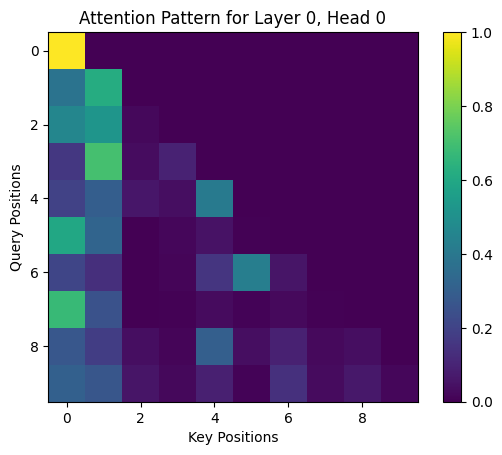

In [60]:
import matplotlib.pyplot as plt
from transformer_lens import utils

# Sample input (replace with actual data)
sample_input = torch.randint(0, cfg.d_vocab, (1, 10)).to(device)

# Collect attention patterns
with torch.no_grad():
    logits, cache = hooked_model.run_with_cache(sample_input)

# Choose the layer and head to visualize
layer = 0  # Change to the desired layer index
head = 0   # Change to the desired head index

# Access attention patterns for the specified layer
attn_patterns = cache[f'blocks.{layer}.attn.hook_pattern']  # Shape: [batch_size, n_heads, seq_len, seq_len]

# Extract the attention pattern for the specified head
attn = attn_patterns[0, head].cpu().numpy()  # Shape: [seq_len, seq_len]

# Visualize the attention pattern
plt.imshow(attn, cmap='viridis')
plt.colorbar()
plt.title(f'Attention Pattern for Layer {layer}, Head {head}')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.show()